In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

path = "/content/drive/MyDrive/cowproject2/nutrition/nutrition_dataset.csv"
df = pd.read_csv(path)

df.head()


,Age_Months,Weight_kg,Breed,Milk_Yield_L_per_day,Health_Status,Disease,Body_Condition_Score,Location,Dry_Matter_Intake_kg_per_day,Energy_MJ_per_day,Crude_Protein_g_per_day,Calcium_g_per_day,Phosphorus_g_per_day,Recommended_Feed_Type
0,99,307,Friesian,14.5,Mild,Mastitis,2.9,Kurunegala,9.12,98.4,910.0,53.4,36.9,Grass
1,93,466,Friesian,15.2,Healthy,NaN,3.8,Badulla,13.17,142.0,1253.0,60.0,40.5,Mixed
2,107,529,Local,10.8,Healthy,NaN,2.9,Badulla,14.31,161.2,1448.0,64.6,56.2,Grass
3,72,424,Ayrshire,19.9,Healthy,NaN,3.4,Monaragala,12.59,147.9,1155.0,59.0,37.0,Mixed
4,62,559,Ayrshire,9.7,Mild,Foot Rot,3.3,Polonnaruwa,14.95,165.9,1308.0,94.9,43.5,Grass


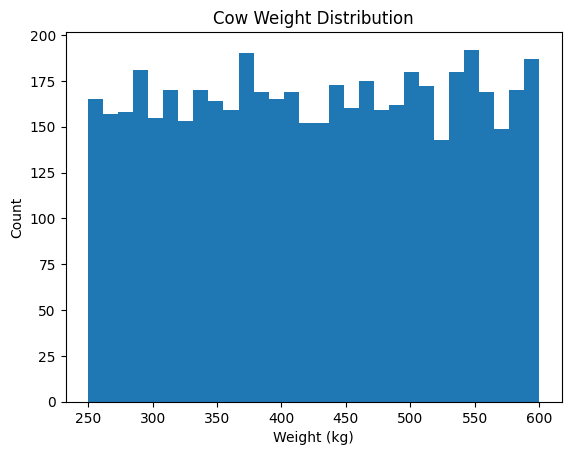

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["Weight_kg"], bins=30)
plt.title("Cow Weight Distribution")
plt.xlabel("Weight (kg)")
plt.ylabel("Count")
plt.show()


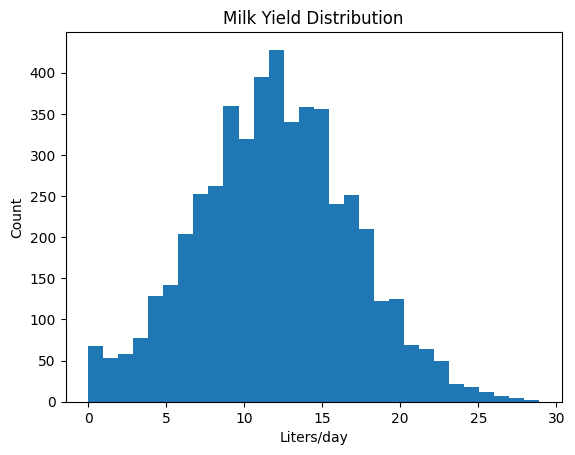

In [5]:
plt.figure()
plt.hist(df["Milk_Yield_L_per_day"], bins=30)
plt.title("Milk Yield Distribution")
plt.xlabel("Liters/day")
plt.ylabel("Count")
plt.show()


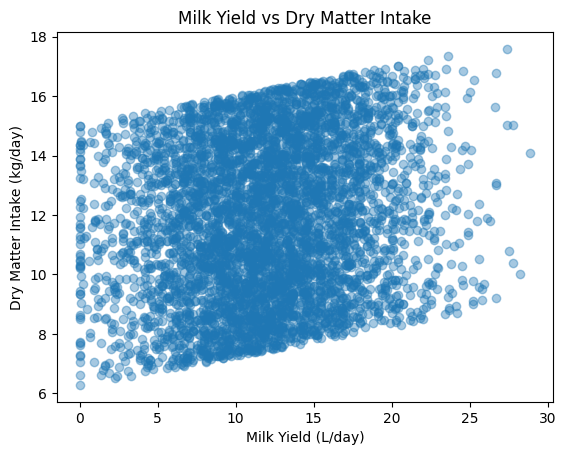

In [6]:
plt.figure()
plt.scatter(df["Milk_Yield_L_per_day"], df["Dry_Matter_Intake_kg_per_day"], alpha=0.4)
plt.xlabel("Milk Yield (L/day)")
plt.ylabel("Dry Matter Intake (kg/day)")
plt.title("Milk Yield vs Dry Matter Intake")
plt.show()


In [7]:
target_cols = [
    "Dry_Matter_Intake_kg_per_day",
    "Calcium_g_per_day",
    "Phosphorus_g_per_day"
]

y = df[target_cols]


In [8]:
X = df.drop(columns=target_cols)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = [
    "Breed",
    "Health_Status",
    "Disease",
    "Location",
    "Recommended_Feed_Type"
]

numeric_cols = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", "passthrough", numeric_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Breed', 'Health_Status',
                                                   'Disease', 'Location',
                                                   'Recommended_Feed_Type']),
                                                 ('num', 'passthrough',
                                                  ['Age_Months', 'Weight_kg',
                                                   'Milk_Yield_L_per_day',
                                                   'Body_Condition_Score',
                                                   'Energy_MJ_per_day',
                                                   'Crude_Protein_g_per_day'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error

preds = model.predict(X_test)

for i, col in enumerate(target_cols):
    print(f"{col}")
    print("  R2 :", r2_score(y_test.iloc[:, i], preds[:, i]))
    print("  MAE:", mean_absolute_error(y_test.iloc[:, i], preds[:, i]))
    print()


Dry_Matter_Intake_kg_per_day
  R2 : 0.9949650421287874
  MAE: 0.14710254999999992

Calcium_g_per_day
  R2 : 0.7934771751497975
  MAE: 6.005266000000001

Phosphorus_g_per_day
  R2 : 0.7619079302865293
  MAE: 4.2515755



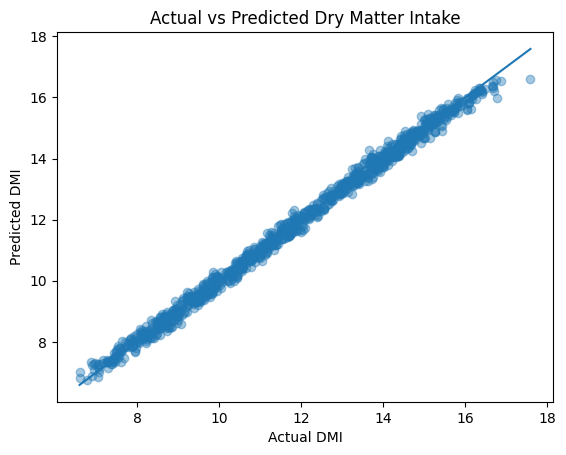

In [12]:
plt.figure()
plt.scatter(
    y_test["Dry_Matter_Intake_kg_per_day"],
    preds[:, 0],
    alpha=0.4
)
plt.xlabel("Actual DMI")
plt.ylabel("Predicted DMI")
plt.title("Actual vs Predicted Dry Matter Intake")
plt.plot(
    [y_test.iloc[:,0].min(), y_test.iloc[:,0].max()],
    [y_test.iloc[:,0].min(), y_test.iloc[:,0].max()]
)
plt.show()


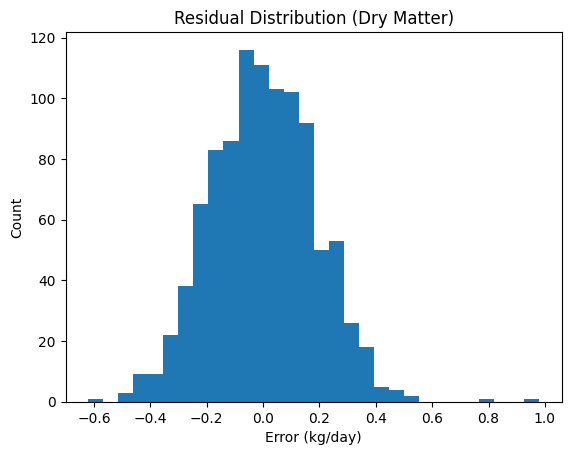

In [13]:
residuals = y_test["Dry_Matter_Intake_kg_per_day"] - preds[:, 0]

plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residual Distribution (Dry Matter)")
plt.xlabel("Error (kg/day)")
plt.ylabel("Count")
plt.show()


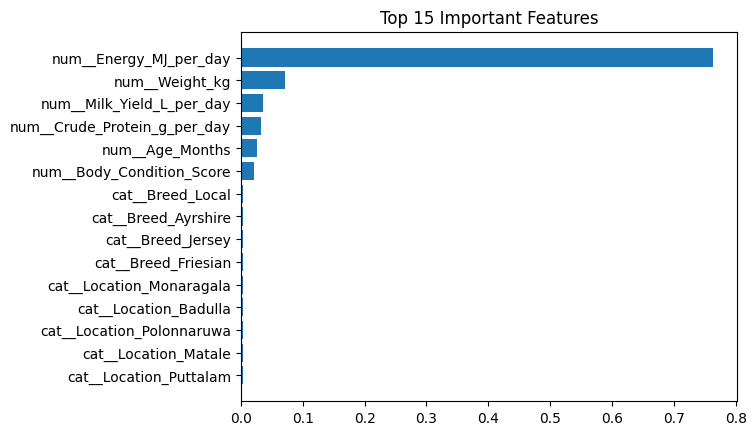

In [14]:
rf = model.named_steps["model"]
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importances = rf.feature_importances_

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure()
plt.barh(imp_df["Feature"], imp_df["Importance"])
plt.title("Top 15 Important Features")
plt.gca().invert_yaxis()
plt.show()


In [15]:
new_cow = pd.DataFrame([{
    "Age_Months": 48,
    "Weight_kg": 480,
    "Breed": "Friesian",
    "Milk_Yield_L_per_day": 18,
    "Health_Status": "Healthy",
    "Disease": "None",
    "Body_Condition_Score": 3.0,
    "Location": "Kurunegala",
    "Energy_MJ_per_day": 185,
    "Crude_Protein_g_per_day": 1600,
    "Recommended_Feed_Type": "Mixed"
}])

prediction = model.predict(new_cow)

result = pd.DataFrame(prediction, columns=target_cols)
result


,Dry_Matter_Intake_kg_per_day,Calcium_g_per_day,Phosphorus_g_per_day
0,15.4033,85.7615,56.7605


In [16]:
print("Predicted Nutrition Requirements")
print("--------------------------------")
print(f"Dry Matter Intake : {result.iloc[0,0]:.2f} kg/day")
print(f"Calcium           : {result.iloc[0,1]:.1f} g/day")
print(f"Phosphorus        : {result.iloc[0,2]:.1f} g/day")


Predicted Nutrition Requirements
--------------------------------
Dry Matter Intake : 15.40 kg/day
Calcium           : 85.8 g/day
Phosphorus        : 56.8 g/day


In [18]:
import joblib

joblib.dump(
    model,
    "/content/drive/MyDrive/cowproject2/nutrition/multi_output_nutrition_model.pkl"
)


['/content/drive/MyDrive/cowproject2/nutrition/multi_output_nutrition_model.pkl']